This notebook makes the figure for the power simulation results. It's mostly copied from [2018-10-30.power_simulation_top_hits.ipynb](2018-10-30.power_simulation_top_hits).

From the previous exploration I did of the results, I decided that converting number rejected into a "power" metric (i.e. "percent of reps where you detect at least half of the top hits") made the results less comprehensible than just showing the raw number of rejections.

I also saw that the trends for all of the different values of "number of top hits" was the same, so I'll just show the results focusing on the top 10 hits.

In this notebook I'll also make some supplementary figures facetgridding all of these separately, in case reviewers/readers are interested in that.

In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn-white')
sns.set_palette(sns.color_palette('muted'))

In [40]:
tophits_fig = '../../figures/final/fig4.power_simulation.png'
tophits_sup = '../../figures/final/suppfig.power_simulation.all_results.png'
tophits_slide = '../../figures/presentation/power_simulation.one_panel.png'

In [41]:
fres = '../../data/analysis/power_simulation.top_hits_sig.50_reps.txt'

df = pd.read_csv(fres, sep='\t')
df.head()

,n_rejected,n_top_hits,taxa_level,n_ctrl,n_case,total_n,perc_case,study,rep
0,0,3,genus,9,1,10,0.10,cdi_schubert,0
1,0,5,genus,9,1,10,0.10,cdi_schubert,0
2,0,10,genus,9,1,10,0.10,cdi_schubert,0
3,0,3,genus,8,3,10,0.25,cdi_schubert,0
4,0,5,genus,8,3,10,0.25,cdi_schubert,0


In [42]:
# Calculate the mean number rejected across reps of the same parameter settings
meandf = (
    df.groupby(['taxa_level', 'study', 'total_n', 'perc_case', 'n_top_hits']).mean()
    ).reset_index()
meandf.head()

,taxa_level,study,total_n,perc_case,n_top_hits,n_rejected,n_ctrl,n_case,rep
0,genus,cdi_schubert,10,0.10,3,0.0,9.0,1.0,24.5
1,genus,cdi_schubert,10,0.10,5,0.0,9.0,1.0,24.5
2,genus,cdi_schubert,10,0.10,10,0.0,9.0,1.0,24.5
3,genus,cdi_schubert,10,0.25,3,0.0,8.0,3.0,24.5
4,genus,cdi_schubert,10,0.25,5,0.0,8.0,3.0,24.5


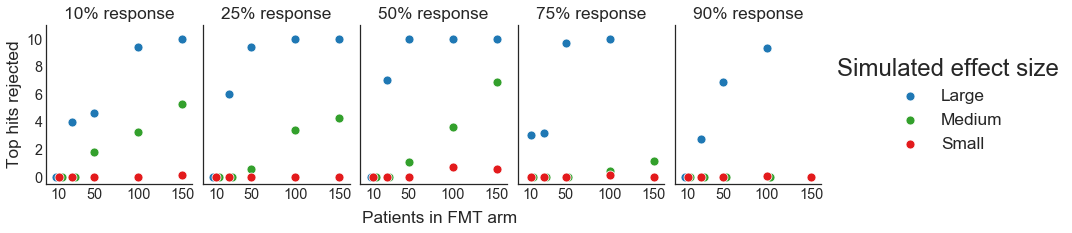

In [43]:
xlabels = [10, 50, 100, 150]

# The ibd_papa study has too few samples to add anything to this figure
toplot = meandf.query('study != "ibd_papa"')

# Keep only n_top_hits == 10
toplot = toplot.query('n_top_hits == 10')

# Add some noise to 'total_n' to have some x-jitter when total_n is zero
offset = 3
n_jitter = []
for _, row in toplot.iterrows():
    if row['n_rejected'] == 0 and row['study'] != 'ob_goodrich':
        if row['study'] == 'cdi_schubert':
            n_jitter.append(row['total_n'] - offset)
        else:
            n_jitter.append(row['total_n'] + offset)
    else:
        n_jitter.append(row['total_n'])
toplot['total_n_jitter'] = n_jitter

# g = sns.catplot(data=toplot, x='total_n', y='n_rejected',
#                 hue='study', col='perc_case', 
#                 palette=sns.color_palette("Paired")[1::2],
#                 legend=False,
#                 **{'s': 10})
g = sns.FacetGrid(data=toplot, 
                  hue='study', col='perc_case',
                  palette=sns.color_palette('Paired')[1:6:2])
g.map(sns.scatterplot, 'total_n_jitter', 'n_rejected', **{'s': 80})

i = 0
for ax in g.axes[0]:
    perc_case = float(ax.get_title().split('=')[1].strip())
    ax.set_title('{:.0f}% response'.format(perc_case*100), fontsize='xx-large')

    ax.set_xlabel('')
    ax.set_xticks(xlabels)
    ax.set_xticklabels([str(s) for s in xlabels], fontsize='x-large')
    
    ax.set_ylim([-0.5, 11])

    if i == 0:
        ax.set_ylabel('Top hits rejected', fontsize='xx-large')
        ax.set_yticklabels(ax.get_yticklabels(), fontsize='x-large')
        i += 1

g.fig.text(0.41, -0.05, 'Patients in FMT arm', ha='center', fontsize='xx-large')

labels = ['Large', 'Medium', 'Small']
handles, _ = ax.get_legend_handles_labels()
lgd = ax.legend(
    handles, labels, title='Simulated effect size',
    loc='center left', bbox_to_anchor=(1, 0.5), 
    fontsize='xx-large', frameon=False)
lgd.get_title().set_fontsize(24)

g.fig.tight_layout()
g.fig.savefig(tophits_fig, bbox_inches='tight')

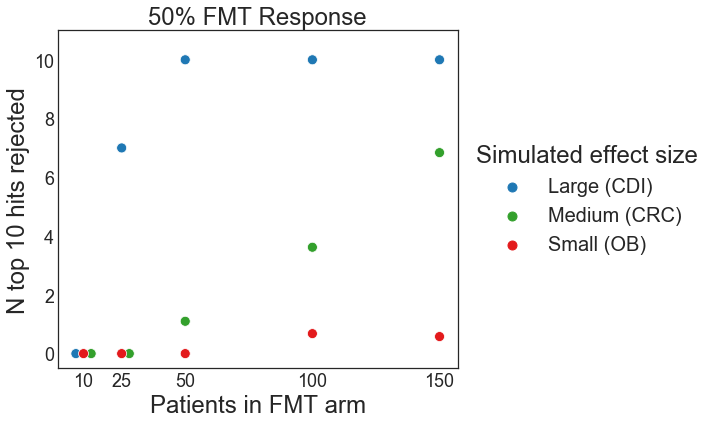

In [44]:
xorder = [10, 25, 50, 100, 150]

# Make just the 50% figure, for slides
fig, ax = plt.subplots(figsize=(10,6))

## The ibd_papa study has too few samples to add anything to this figure
#toplot = meandf.query('study != "ibd_papa"')

## Keep only n_top_hits == 10
#toplot = toplot.query('n_top_hits == 10')

# Keep only 50%
toplot = toplot.query('perc_case == 0.5')

sns.scatterplot(data=toplot, x='total_n_jitter', y='n_rejected',
              hue='study', 
              palette=sns.color_palette("Paired")[1:6:2],
              ax=ax,
              **{'s': 100})



ax.set_ylim([-0.5, 11])
ax.set_yticks([0, 2, 4, 6, 8, 10])
ax.set_yticklabels([str(i) for i in [0, 2, 4, 6, 8, 10]], fontsize=18)

#ax.set_yticklabels(['0', '2', '4', '6', '8', '10'], fontsize=18)
#ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)
ax.set_ylabel('N top 10 hits rejected', fontsize=24)

ax.set_xlabel('Patients in FMT arm', ha='center', fontsize=24)
ax.set_xticks(xorder)
ax.set_xticklabels([str(i) for i in xorder], fontsize=18)

labels = ['Large (CDI)', 'Medium (CRC)', 'Small (OB)']
handles = ax.get_legend_handles_labels()[0][1:]
lgd = ax.legend(
    handles, labels, title='Simulated effect size',
    loc='center left', bbox_to_anchor=(1, 0.5), 
    fontsize=20, frameon=False, markerscale=1.5)
lgd.get_title().set_fontsize(24)

ax.set_title('50% FMT Response', fontsize=24)

fig.tight_layout()
fig.savefig(tophits_slide)

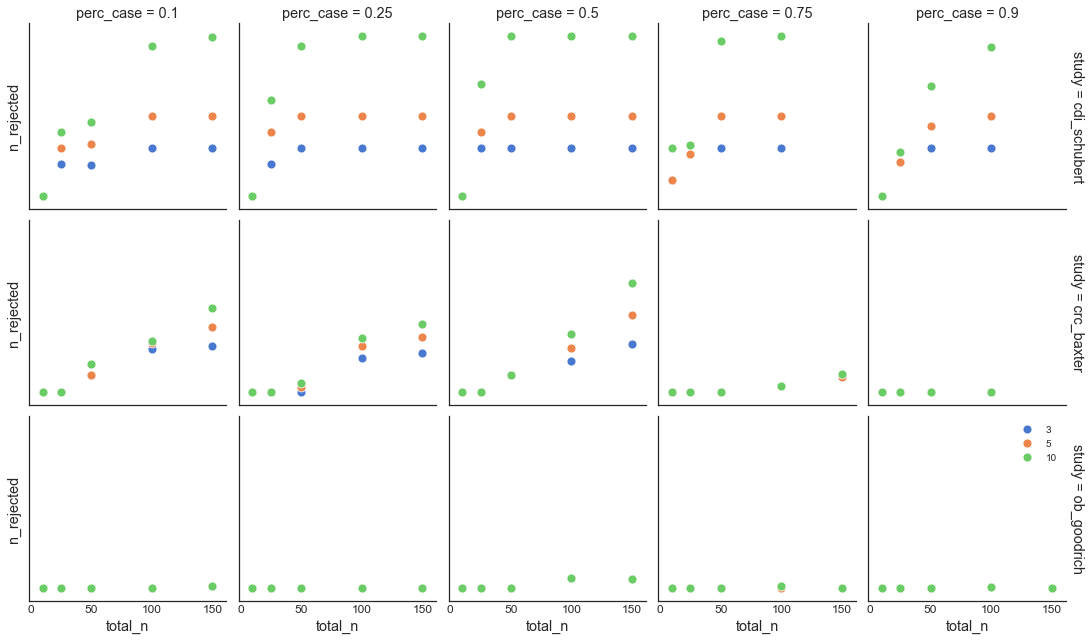

In [45]:
# Supplementary figure, showing mean rejections per parameter setting,
# Don't wanna figure out legend right now so will just put that in the caption.

g = sns.FacetGrid(col='perc_case', row='study', 
                  data=meandf, hue='n_top_hits',
                  #palette=sns.color_palette('Paired')[1:6:2],
                  sharey=True, margin_titles=True)
g.map(sns.scatterplot, 'total_n', 'n_rejected',
      **{'s': 80})

right_labels = []
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize='x-large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
    ax.set_xticklabels(ax.get_xticklabels(), fontsize='large')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize='large')
    if ax.texts:
        # This contains the right ylabel text
        txt = ax.texts[0]
        ax.text(txt.get_unitless_position()[0], txt.get_unitless_position()[1], 
                txt.get_text(), 
                transform=ax.transAxes,
                va='center',
                fontsize='x-large',
                rotation=-90)
        # Remove the original text
        right_labels.append(ax.texts[1])
        ax.texts[0].remove()
plt.legend(loc='upper right')#, bbox_to_anchor=(1, 0.5))
g.fig.tight_layout()
g.fig.savefig(tophits_sup, bbox_inches='tight')